# Modeling and Evaluation.

### Importing all the necessaary Libraries.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.impute import SimpleImputer
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import numpy as np
import datetime
import warnings
warnings.filterwarnings('ignore')

### Reading Data into a Data Frame

In [2]:
df=pd.read_csv('Maryland_Statewide_Vehicle_Crashes_-_Vehicle_Details.csv')

In [3]:
df.head()

,HARM_EVENT_DESC,HARM_EVENT_CODE,CONTI_DIRECTION_DESC,CONTI_DIRECTION_CODE,DAMAGE_DESC,DAMAGE_CODE,MOVEMENT_DESC,MOVEMENT_CODE,VIN_NO,REPORT_NO,...,TOWED_VEHICLE_CONFIG_DESC,TOWED_VEHICLE_CONFIG_CODE,AREA_DAMAGED_CODE_IMP1,AREA_DAMAGED_CODE1,AREA_DAMAGED_CODE2,AREA_DAMAGED_CODE3,AREA_DAMAGED_CODE_MAIN_DESC,AREA_DAMAGED_CODE_MAIN,YEAR,Quarter
0,Other Vehicle,1.0,North,N,Unknown,99,Unknown,99.0,NaN,AE5057004X,...,Unknown,99,11.0,10.0,11.0,12.0,Eleven o'clock,11.0,2020,Q2
1,Other Vehicle,1.0,North,N,Superficial,2,Moving Constant Speed,1.0,NMTKHMBX0JR025092,MSP7221001P,...,Not Applicable,0,12.0,6.0,12.0,NaN,Twelve o'clock,12.0,2020,Q2
2,Other Vehicle,1.0,South,S,Functional,3,Stopped in Traffic Lane,6.0,2GNAXPEX5K6103012,DA37010040,...,Not Applicable,0,6.0,6.0,NaN,NaN,Six o'clock,6.0,2020,Q2
3,Fixed Object,9.0,Unknown,U,Unknown,99,Not Applicable,0.0,NaN,MDTA1791002C,...,Not Applicable,0,99.0,99.0,NaN,NaN,Unknown,99.0,2020,Q2
4,Other Vehicle,1.0,East,E,Disabling,4,Slowing or Stopping,3.0,5FNRL18672B048550,AE456100BL,...,Not Applicable,0,6.0,6.0,12.0,NaN,Six o'clock,6.0,2020,Q2


As per the EDA we are dropping the unnecessary columns. This will give us a new data set with necessary columns.

In [4]:
# Using drop function to drop the unnecassary columns
df_new = df.drop(columns=['HARM_EVENT_CODE', 'CONTI_DIRECTION_DESC',
       'CONTI_DIRECTION_CODE', 'DAMAGE_CODE',
       'MOVEMENT_CODE', 'VIN_NO', 'REPORT_NO', 'CV_BODY_TYPE_DESC',
       'CV_BODY_TYPE_CODE', 'VEH_YEAR', 'VEH_MAKE', 'VEH_MODEL',
       'COMMERCIAL_FLAG_DESC', 'COMMERCIAL_FLAG', 'HZM_NUM',
       'TOWED_AWAY_FLAG_DESC', 'TOWED_AWAY_FLAG', 'NUM_AXLES', 'GVW_DESC',
       'GVW_CODE', 'GOING_DIRECTION_DESC', 'GOING_DIRECTION_CODE', 'BODY_TYPE_CODE', 'DRIVERLESS_FLAG_DESC',
       'DRIVERLESS_FLAG', 'FIRE_FLAG_DESC', 'FIRE_FLAG',
       'PARKED_FLAG',
       'HIT_AND_RUN_FLAG', 'HAZMAT_SPILL_FLAG_DESC', 'HAZMAT_SPILL_FLAG',
       'VEHICLE_ID', 'TOWED_VEHICLE_CONFIG_CODE',
       'AREA_DAMAGED_CODE_IMP1', 'AREA_DAMAGED_CODE1', 'AREA_DAMAGED_CODE2',
       'AREA_DAMAGED_CODE3',
       'AREA_DAMAGED_CODE_MAIN', 'YEAR', 'Quarter'])

Our target variable is "DAMAGE_DESC". We are looking for how many values it holds.

In [5]:
df_new.DAMAGE_DESC.value_counts()

Disabling         498282
Superficial       363011
Functional        355315
Unknown            95323
Destroyed          77503
No Damage          40963
Not Applicable      7062
Other               1349
Name: DAMAGE_DESC, dtype: int64

We have many classes in the target variable which will result in taking longer time for modelling and gives less precision and recall. So I am planning to shrink them to 2 classes.

My main goal is to predict whether a vehicle is able to move on it's own or else we it is not functional. I have considered functional, Nod Damage and Not Applicable as Functional. The rest are Not Functional

So I have created a new column new_damage_desc where I considered only Functional and No Damage as Functional and assigned rest of the classes as Not Functional.

In [6]:
df_new['new_damage_desc'] = ['Functional' if x == 'Functional' or x == 'No Damage' or x == 'Not Applicable' else 'Not Functional' for x in df_new['DAMAGE_DESC']]

Below is the Plot for target variable classes.

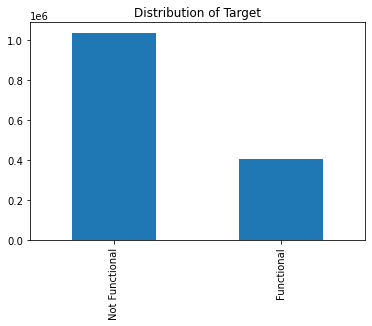

In [7]:
df_new['new_damage_desc'].value_counts().plot.bar()
plt.title('Distribution of Target')
plt.show()

We can see that there is class imbalance so we should predict by solving these class imbalances.

##### Feature Engineering.

In [8]:
df_new.head()

,HARM_EVENT_DESC,DAMAGE_DESC,MOVEMENT_DESC,BODY_TYPE_DESC,PARKED_FLAG_DESC,SPEED_LIMIT,HIT_AND_RUN_FLAG_DESC,TOWED_VEHICLE_CONFIG_DESC,AREA_DAMAGED_CODE_MAIN_DESC,new_damage_desc
0,Other Vehicle,Unknown,Unknown,NaN,No,25,Yes,Unknown,Eleven o'clock,Not Functional
1,Other Vehicle,Superficial,Moving Constant Speed,Passenger Car,No,55,No,Not Applicable,Twelve o'clock,Not Functional
2,Other Vehicle,Functional,Stopped in Traffic Lane,(Sport) Utility Vehicle,No,30,No,Not Applicable,Six o'clock,Functional
3,Fixed Object,Unknown,Not Applicable,NaN,No,35,Yes,Not Applicable,Unknown,Not Functional
4,Other Vehicle,Disabling,Slowing or Stopping,Passenger Car,No,35,No,Not Applicable,Six o'clock,Not Functional


I have taken the categorical columns and Numerical columns and created pipelines respectively. I have used imputing method of mean for numerical and most_frequent for categorical pipeline. Using them I have created a processing pipeline.

Used Standard Scalar for strandadizig of any anomalies in the data, So the data will be standardized to a sing scale.
Used One Hot Encoder to bring the categorical values to a nominal value.

In [9]:
cat_columns = ['HARM_EVENT_DESC','MOVEMENT_DESC','BODY_TYPE_DESC','PARKED_FLAG_DESC','HIT_AND_RUN_FLAG_DESC','TOWED_VEHICLE_CONFIG_DESC','AREA_DAMAGED_CODE_MAIN_DESC']
num_columns = ['SPEED_LIMIT']

num_pipeline = Pipeline([('impute_missing_n', SimpleImputer(missing_values = np.NaN, strategy='median')),('standardize_num', StandardScaler())])

cat_pipeline = Pipeline([('impute_missing_c', SimpleImputer(missing_values= np.NaN,strategy='most_frequent')),('create_dummies_cats', OneHotEncoder(drop='first',handle_unknown='ignore'))
                         ])

processing_pipeline = ColumnTransformer(transformers=[('proc_numeric', num_pipeline, num_columns),
                                                      ('create_dummies', cat_pipeline, cat_columns)])

processing_pipeline

ColumnTransformer(transformers=[('proc_numeric',
                                 Pipeline(steps=[('impute_missing_n',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardize_num',
                                                  StandardScaler())]),
                                 ['SPEED_LIMIT']),
                                ('create_dummies',
                                 Pipeline(steps=[('impute_missing_c',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('create_dummies_cats',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['HARM_EVENT_DESC', 'MOVEMENT_DESC',
                                  'BODY_TYPE_DESC', 'PARKED_FLAG_DESC',
      

Processing Pipeline is created.

##### Splitting the Data set into test and train using train split

As I have created new target variable. I have removed both these from the features and considered the new target variable for y. Used 20% of the Data for training and testing.

In [10]:
features = [x for x in df_new.columns if x != 'DAMAGE_DESC' and x!= 'new_damage_desc']
X = df_new[features]
y = df_new['new_damage_desc']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                          test_size=0.2,
                                                          random_state = 123)

##### Logistic Regression

In [11]:
st = datetime.datetime.now()
p = Pipeline([('processing pipeline', processing_pipeline), 
              ('model', LogisticRegression(solver = 'liblinear'))
             ])

params = {'model__C': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(p, param_grid=params, scoring='recall_macro', cv=10, refit=True)
grid_search = grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)
print("\n")
print(f'Validation score: {grid_search.best_score_:.2%}')
print(f'Test score: {grid_search.score(X_test, y_test):.2%}')

print("--- %s seconds ---" % (datetime.datetime.now() - st))

Pipeline(steps=[('processing pipeline',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('impute_missing_n',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardize_num',
                                                                   StandardScaler())]),
                                                  ['SPEED_LIMIT']),
                                                 ('create_dummies',
                                                  Pipeline(steps=[('impute_missing_c',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('create_dummies_cats',
                                                                   OneHotEncoder(drop='first',
              

Created a logistic regression and have used scoring as recall_macro because we have class imbalances.
As we can see the c value has picked 100 so below we are performing a secondary search for the same

In [12]:
st = datetime.datetime.now()
p = Pipeline([('processing pipeline', processing_pipeline), 
              ('model', LogisticRegression(solver = 'liblinear'))
             ])

params = {'model__C': [300,400,500]}
grid_search = GridSearchCV(p, param_grid=params, scoring='recall_macro', cv=10, refit=True)
grid_search = grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)
print("\n")
print(f'Validation score: {grid_search.best_score_:.2%}')
print(f'Test score: {grid_search.score(X_test, y_test):.2%}')
print("--- %s seconds ---" % (datetime.datetime.now() - st))

Pipeline(steps=[('processing pipeline',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('impute_missing_n',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardize_num',
                                                                   StandardScaler())]),
                                                  ['SPEED_LIMIT']),
                                                 ('create_dummies',
                                                  Pipeline(steps=[('impute_missing_c',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('create_dummies_cats',
                                                                   OneHotEncoder(drop='first',
              

As we can see the c value has changed to 500, so developed a classification report below with c value 500. The classes have imbalances so we are using class weights as balanced, so the functional class will reach the non functional values.

In [30]:
logistic_model = Pipeline([('processing_pipeline', processing_pipeline),('model', LogisticRegression(C=500, class_weight='balanced', solver='liblinear'))])
logistic_model.fit(X_train,y_train)
logistic_predict = logistic_model.predict(X_test)
print(classification_report(y_test, logistic_predict))

                precision    recall  f1-score   support

    Functional       0.37      0.60      0.46     80600
Not Functional       0.79      0.60      0.69    207162

      accuracy                           0.60    287762
     macro avg       0.58      0.60      0.57    287762
  weighted avg       0.67      0.60      0.62    287762



We can see that we have got an accuracy of 58% and a recall of 60%. Logistic regression model has given good results let us check the ROC curve.

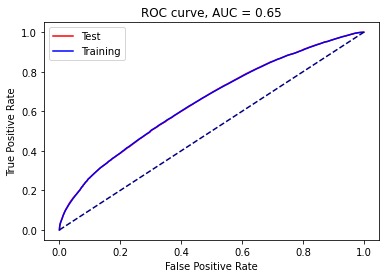

In [14]:
y_testprobability = logistic_model.predict_proba(X_test)
y_trainprobability = logistic_model.predict_proba(X_train)

def roc(y, prob):
    fpr, tpr, _ = roc_curve(y, prob, pos_label='Not Functional')
    return fpr, tpr
fpr_test, tpr_test = roc(y_test, y_testprobability[:,1])
fpr_train, tpr_train = roc(y_train, y_trainprobability[:,1])
auc = roc_auc_score(y_test, y_testprobability[:,1], multi_class = 'ovr')
plt.plot(fpr_test, tpr_test,'-r')
plt.plot(fpr_train, tpr_train,'-b')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve, AUC = %.2f'%auc)
plt.legend(['Test','Training'])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.show()

#### Observations.

    By using logistic regression we got a macro avg of 58% precision and recall of 60%.
    When it comes to damage, Not Functional has high precision with 79% and recall of 60%..
    For Damage resulting in functional, it has a precision of 37% and recall of 60%.
    The ROC Curve has an AUC of 0.65.

##### Decision Tree Classifier.

In [15]:
st = datetime.datetime.now()
p = Pipeline([('processing pipeline', processing_pipeline), 
              ('model', DecisionTreeClassifier())
             ])

params = {'model__max_depth': [1, 7, 15], 'model__min_samples_split' : [0.1, 0.3, 0.8]}

grid_search = GridSearchCV(p, param_grid=params, scoring='recall_macro', cv=10, refit=True)
grid_search = grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)
print("\n")
print(f'Validation score: {grid_search.best_score_:.2%}')
print(f'Test score: {grid_search.score(X_test, y_test):.2%}')
print("--- %s seconds ---" % (datetime.datetime.now() - st))

Pipeline(steps=[('processing pipeline',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('impute_missing_n',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardize_num',
                                                                   StandardScaler())]),
                                                  ['SPEED_LIMIT']),
                                                 ('create_dummies',
                                                  Pipeline(steps=[('impute_missing_c',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('create_dummies_cats',
                                                                   OneHotEncoder(drop='first',
              

We have got similar validation score compared to the Logistic Regression Model. The max depth is 7 and min_samples_split is 0.1. So let us perform a secondary search.

As it was 7 we have taken max_depth 6,7,8 the nearest neighbours. min_samples_split as 0.01,0.05,0.1 the nearest neighbours.

In [16]:
st = datetime.datetime.now()
p = Pipeline([('processing pipeline', processing_pipeline), 
              ('model', DecisionTreeClassifier())
             ])

params = {'model__max_depth': [1,2,3,4,5,6,], 'model__min_samples_split' : [0.01, 0.05, 0.1]}

grid_search = GridSearchCV(p, param_grid=params, scoring='recall_macro', cv=10, refit=True)
grid_search = grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)
print("\n")
print(f'Validation score: {grid_search.best_score_:.2%}')
print(f'Test score: {grid_search.score(X_test, y_test):.2%}')
print("--- %s seconds ---" % (datetime.datetime.now() - st))

Pipeline(steps=[('processing pipeline',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('impute_missing_n',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardize_num',
                                                                   StandardScaler())]),
                                                  ['SPEED_LIMIT']),
                                                 ('create_dummies',
                                                  Pipeline(steps=[('impute_missing_c',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('create_dummies_cats',
                                                                   OneHotEncoder(drop='first',
              

We can see the validation scores have increased so we have used 5 as the max_depth and min_samples_split as 0.05. Used class_weights as balanced to balance the class imbalances.

In [17]:
decision_model = Pipeline([('processing_pipeline', processing_pipeline),('model', DecisionTreeClassifier(max_depth=5, class_weight='balanced', min_samples_split=0.05))])
decision_model.fit(X_train,y_train)
decision_predict = decision_model.predict(X_test)
print(classification_report(y_test, decision_predict))

                precision    recall  f1-score   support

    Functional       0.34      0.66      0.45     80600
Not Functional       0.79      0.51      0.62    207162

      accuracy                           0.55    287762
     macro avg       0.57      0.58      0.53    287762
  weighted avg       0.67      0.55      0.57    287762



We can see that we have got an macro avg of 57% for precision and a recall of 58%. There isn't a signicficant increase compared to logistic regression, let us check the ROC curve.

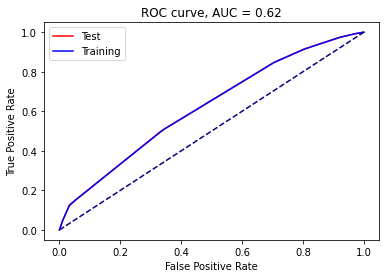

In [18]:
from sklearn.metrics import roc_auc_score
import numpy as np
y_testprobability = decision_model.predict_proba(X_test)
y_trainprobability = decision_model.predict_proba(X_train)

def roc(y, prob):
    fpr, tpr, _ = roc_curve(y, prob, pos_label='Not Functional')
    return fpr, tpr
fpr_test, tpr_test = roc(y_test, y_testprobability[:,1])
fpr_train, tpr_train = roc(y_train, y_trainprobability[:,1])
auc = roc_auc_score(y_test, y_testprobability[:,1], multi_class = 'ovr')
plt.plot(fpr_test, tpr_test,'-r')
plt.plot(fpr_train, tpr_train,'-b')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve, AUC = %.2f'%auc)
plt.legend(['Test','Training'])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.show()

#### Observations.

    By using Decision Tree we got a macro avg of 57% for precision and 58% recall.
    When it comes damage, Not Functional has high precision with 79% and recall of 51%..
    For Damage resulting in functional, it has a precision of 34% and recall of 66%.
    The ROC Curve has an AUC of 0.62.

Logistic regression has better results compared to Decision tree classifier. Let us proceed to Gradient Boosting Classifier

##### Gradient Boosting.

In [19]:
st = datetime.datetime.now()
gb_p = Pipeline([('processing', processing_pipeline),
             ('gb', GradientBoostingClassifier())])

params_gb = {'gb__max_depth': [1, 3],
         'gb__n_estimators': [10,20, 30]
         }
gcv_gb = GridSearchCV(gb_p, param_grid = params_gb, cv=2, scoring='recall_macro', verbose=10)
gcv_gb = gcv_gb.fit(X_train, y_train)
print(gcv_gb.best_estimator_)
print("\n")
print(f'Validation score: {gcv_gb.best_score_:.2%}')
print(f'Test score: {gcv_gb.score(X_test, y_test):.2%}')
print("--- %s seconds ---" % (datetime.datetime.now() - st))

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2; 1/6] START gb__max_depth=1, gb__n_estimators=10........................
[CV 1/2; 1/6] END gb__max_depth=1, gb__n_estimators=10;, score=0.500 total time=   9.3s
[CV 2/2; 1/6] START gb__max_depth=1, gb__n_estimators=10........................
[CV 2/2; 1/6] END gb__max_depth=1, gb__n_estimators=10;, score=0.500 total time=   9.3s
[CV 1/2; 2/6] START gb__max_depth=1, gb__n_estimators=20........................
[CV 1/2; 2/6] END gb__max_depth=1, gb__n_estimators=20;, score=0.500 total time=  11.9s
[CV 2/2; 2/6] START gb__max_depth=1, gb__n_estimators=20........................
[CV 2/2; 2/6] END gb__max_depth=1, gb__n_estimators=20;, score=0.500 total time=  11.8s
[CV 1/2; 3/6] START gb__max_depth=1, gb__n_estimators=30........................
[CV 1/2; 3/6] END gb__max_depth=1, gb__n_estimators=30;, score=0.501 total time=  14.7s
[CV 2/2; 3/6] START gb__max_depth=1, gb__n_estimators=30........................
[CV 2/2; 3/6] 

We can see that it has selected the n_estimators as 30 so we are doing a secondary search for this.

In [20]:
st = datetime.datetime.now()
gb_p = Pipeline([('processing', processing_pipeline),
             ('gb', GradientBoostingClassifier())])

params_gb = {'gb__max_depth': [1, 3],
         'gb__n_estimators': [100,200, 300]
         }

gcv_gb = GridSearchCV(gb_p, param_grid = params_gb, cv=2, scoring='recall_macro', verbose=10)
gcv_gb = gcv_gb.fit(X_train, y_train)
print(gcv_gb.best_estimator_)
print("\n")
print(f'Validation score: {gcv_gb.best_score_:.2%}')
print(f'Test score: {gcv_gb.score(X_test, y_test):.2%}')
print("--- %s seconds ---" % (datetime.datetime.now() - st))

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2; 1/6] START gb__max_depth=1, gb__n_estimators=100.......................
[CV 1/2; 1/6] END gb__max_depth=1, gb__n_estimators=100;, score=0.508 total time=  32.0s
[CV 2/2; 1/6] START gb__max_depth=1, gb__n_estimators=100.......................
[CV 2/2; 1/6] END gb__max_depth=1, gb__n_estimators=100;, score=0.509 total time=  31.9s
[CV 1/2; 2/6] START gb__max_depth=1, gb__n_estimators=200.......................
[CV 1/2; 2/6] END gb__max_depth=1, gb__n_estimators=200;, score=0.513 total time=  57.6s
[CV 2/2; 2/6] START gb__max_depth=1, gb__n_estimators=200.......................
[CV 2/2; 2/6] END gb__max_depth=1, gb__n_estimators=200;, score=0.513 total time= 1.3min
[CV 1/2; 3/6] START gb__max_depth=1, gb__n_estimators=300.......................
[CV 1/2; 3/6] END gb__max_depth=1, gb__n_estimators=300;, score=0.515 total time= 1.7min
[CV 2/2; 3/6] START gb__max_depth=1, gb__n_estimators=300.......................
[CV 2/2; 

Now after the secondary search we are checking the classification report.

In [21]:
gb_model = Pipeline([('processing_pipeline', processing_pipeline),('model', GradientBoostingClassifier(n_estimators=300))])
gb_model.fit(X_train,y_train)
gb_predict = gb_model.predict(X_test)
print(classification_report(y_test, decision_predict))

                precision    recall  f1-score   support

    Functional       0.34      0.66      0.45     80600
Not Functional       0.79      0.51      0.62    207162

      accuracy                           0.55    287762
     macro avg       0.57      0.58      0.53    287762
  weighted avg       0.67      0.55      0.57    287762



We can see that we have got an macro avg of 57% for precision and a recall of 58%. There isn't an increase compared to logistic regression, let us check the ROC curve.

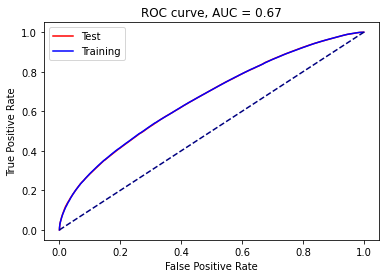

In [22]:
y_testprobability = gb_model.predict_proba(X_test)
y_trainprobability = gb_model.predict_proba(X_train)

def roc(y, prob):
    fpr, tpr, _ = roc_curve(y, prob, pos_label='Not Functional')
    return fpr, tpr
fpr_test, tpr_test = roc(y_test, y_testprobability[:,1])
fpr_train, tpr_train = roc(y_train, y_trainprobability[:,1])
auc = roc_auc_score(y_test, y_testprobability[:,1], multi_class = 'ovr')
plt.plot(fpr_test, tpr_test,'-r')
plt.plot(fpr_train, tpr_train,'-b')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve, AUC = %.2f'%auc)
plt.legend(['Test','Training'])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.show()

#### Observations.

    By using Gradient Boosting classifier we got a macro avg of 57% for precision and 58% recall.
    When it comes damage, Not Functional has high precision with 79% and recall of 51%.
    For Damage resulting in functional, it has a precision of 34% and recall of 66%.
    The ROC Curve has an AUC of 0.67 which is greater than logistic regression.

##### Random Forrest

In [23]:
st = datetime.datetime.now()
rf_p = Pipeline([('processing', processing_pipeline),
             ('rf', RandomForestClassifier())])
param_grid_rf = [{'rf__max_depth': [5, 10, 15],
               'rf__n_estimators': [10, 50, 100],
               'rf__class_weight': ['balanced', 'balanced_subsample'],
               'rf__max_samples': [1000, 2000, 5000]
              }]
gcv_rf = GridSearchCV(estimator=rf_p, param_grid=param_grid_rf, scoring='recall_macro', refit=True, verbose=10)
gcv_rf = gcv_rf.fit(X_train, y_train)
print(gcv_rf.best_estimator_)
print("\n")
print(f'Validation score: {gcv_rf.best_score_:.2%}')
print(f'Test score: {gcv_rf.score(X_test, y_test):.2%}')
print("--- %s seconds ---" % (datetime.datetime.now() - st))

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5; 1/54] START rf__class_weight=balanced, rf__max_depth=5, rf__max_samples=1000, rf__n_estimators=10
[CV 1/5; 1/54] END rf__class_weight=balanced, rf__max_depth=5, rf__max_samples=1000, rf__n_estimators=10;, score=0.589 total time=   7.1s
[CV 2/5; 1/54] START rf__class_weight=balanced, rf__max_depth=5, rf__max_samples=1000, rf__n_estimators=10
[CV 2/5; 1/54] END rf__class_weight=balanced, rf__max_depth=5, rf__max_samples=1000, rf__n_estimators=10;, score=0.580 total time=   7.2s
[CV 3/5; 1/54] START rf__class_weight=balanced, rf__max_depth=5, rf__max_samples=1000, rf__n_estimators=10
[CV 3/5; 1/54] END rf__class_weight=balanced, rf__max_depth=5, rf__max_samples=1000, rf__n_estimators=10;, score=0.580 total time=   7.2s
[CV 4/5; 1/54] START rf__class_weight=balanced, rf__max_depth=5, rf__max_samples=1000, rf__n_estimators=10
[CV 4/5; 1/54] END rf__class_weight=balanced, rf__max_depth=5, rf__max_samples=1000, rf__n_estim

[CV 4/5; 7/54] END rf__class_weight=balanced, rf__max_depth=5, rf__max_samples=5000, rf__n_estimators=10;, score=0.588 total time=   7.3s
[CV 5/5; 7/54] START rf__class_weight=balanced, rf__max_depth=5, rf__max_samples=5000, rf__n_estimators=10
[CV 5/5; 7/54] END rf__class_weight=balanced, rf__max_depth=5, rf__max_samples=5000, rf__n_estimators=10;, score=0.592 total time=   7.3s
[CV 1/5; 8/54] START rf__class_weight=balanced, rf__max_depth=5, rf__max_samples=5000, rf__n_estimators=50
[CV 1/5; 8/54] END rf__class_weight=balanced, rf__max_depth=5, rf__max_samples=5000, rf__n_estimators=50;, score=0.594 total time=  12.5s
[CV 2/5; 8/54] START rf__class_weight=balanced, rf__max_depth=5, rf__max_samples=5000, rf__n_estimators=50
[CV 2/5; 8/54] END rf__class_weight=balanced, rf__max_depth=5, rf__max_samples=5000, rf__n_estimators=50;, score=0.591 total time=  12.6s
[CV 3/5; 8/54] START rf__class_weight=balanced, rf__max_depth=5, rf__max_samples=5000, rf__n_estimators=50
[CV 3/5; 8/54] END r

[CV 3/5; 14/54] END rf__class_weight=balanced, rf__max_depth=10, rf__max_samples=2000, rf__n_estimators=50;, score=0.591 total time=  14.5s
[CV 4/5; 14/54] START rf__class_weight=balanced, rf__max_depth=10, rf__max_samples=2000, rf__n_estimators=50
[CV 4/5; 14/54] END rf__class_weight=balanced, rf__max_depth=10, rf__max_samples=2000, rf__n_estimators=50;, score=0.594 total time=  14.5s
[CV 5/5; 14/54] START rf__class_weight=balanced, rf__max_depth=10, rf__max_samples=2000, rf__n_estimators=50
[CV 5/5; 14/54] END rf__class_weight=balanced, rf__max_depth=10, rf__max_samples=2000, rf__n_estimators=50;, score=0.592 total time=  14.3s
[CV 1/5; 15/54] START rf__class_weight=balanced, rf__max_depth=10, rf__max_samples=2000, rf__n_estimators=100
[CV 1/5; 15/54] END rf__class_weight=balanced, rf__max_depth=10, rf__max_samples=2000, rf__n_estimators=100;, score=0.593 total time=  22.7s
[CV 2/5; 15/54] START rf__class_weight=balanced, rf__max_depth=10, rf__max_samples=2000, rf__n_estimators=100
[

[CV 1/5; 21/54] END rf__class_weight=balanced, rf__max_depth=15, rf__max_samples=1000, rf__n_estimators=100;, score=0.572 total time=  24.4s
[CV 2/5; 21/54] START rf__class_weight=balanced, rf__max_depth=15, rf__max_samples=1000, rf__n_estimators=100
[CV 2/5; 21/54] END rf__class_weight=balanced, rf__max_depth=15, rf__max_samples=1000, rf__n_estimators=100;, score=0.575 total time=  24.7s
[CV 3/5; 21/54] START rf__class_weight=balanced, rf__max_depth=15, rf__max_samples=1000, rf__n_estimators=100
[CV 3/5; 21/54] END rf__class_weight=balanced, rf__max_depth=15, rf__max_samples=1000, rf__n_estimators=100;, score=0.576 total time=  24.7s
[CV 4/5; 21/54] START rf__class_weight=balanced, rf__max_depth=15, rf__max_samples=1000, rf__n_estimators=100
[CV 4/5; 21/54] END rf__class_weight=balanced, rf__max_depth=15, rf__max_samples=1000, rf__n_estimators=100;, score=0.577 total time=  24.7s
[CV 5/5; 21/54] START rf__class_weight=balanced, rf__max_depth=15, rf__max_samples=1000, rf__n_estimators=

[CV 4/5; 27/54] END rf__class_weight=balanced, rf__max_depth=15, rf__max_samples=5000, rf__n_estimators=100;, score=0.597 total time=  35.1s
[CV 5/5; 27/54] START rf__class_weight=balanced, rf__max_depth=15, rf__max_samples=5000, rf__n_estimators=100
[CV 5/5; 27/54] END rf__class_weight=balanced, rf__max_depth=15, rf__max_samples=5000, rf__n_estimators=100;, score=0.601 total time=  35.1s
[CV 1/5; 28/54] START rf__class_weight=balanced_subsample, rf__max_depth=5, rf__max_samples=1000, rf__n_estimators=10
[CV 1/5; 28/54] END rf__class_weight=balanced_subsample, rf__max_depth=5, rf__max_samples=1000, rf__n_estimators=10;, score=0.586 total time=   6.5s
[CV 2/5; 28/54] START rf__class_weight=balanced_subsample, rf__max_depth=5, rf__max_samples=1000, rf__n_estimators=10
[CV 2/5; 28/54] END rf__class_weight=balanced_subsample, rf__max_depth=5, rf__max_samples=1000, rf__n_estimators=10;, score=0.586 total time=   6.6s
[CV 3/5; 28/54] START rf__class_weight=balanced_subsample, rf__max_depth=5

[CV 5/5; 33/54] END rf__class_weight=balanced_subsample, rf__max_depth=5, rf__max_samples=2000, rf__n_estimators=100;, score=0.596 total time=  20.7s
[CV 1/5; 34/54] START rf__class_weight=balanced_subsample, rf__max_depth=5, rf__max_samples=5000, rf__n_estimators=10
[CV 1/5; 34/54] END rf__class_weight=balanced_subsample, rf__max_depth=5, rf__max_samples=5000, rf__n_estimators=10;, score=0.593 total time=   6.7s
[CV 2/5; 34/54] START rf__class_weight=balanced_subsample, rf__max_depth=5, rf__max_samples=5000, rf__n_estimators=10
[CV 2/5; 34/54] END rf__class_weight=balanced_subsample, rf__max_depth=5, rf__max_samples=5000, rf__n_estimators=10;, score=0.595 total time=   6.8s
[CV 3/5; 34/54] START rf__class_weight=balanced_subsample, rf__max_depth=5, rf__max_samples=5000, rf__n_estimators=10
[CV 3/5; 34/54] END rf__class_weight=balanced_subsample, rf__max_depth=5, rf__max_samples=5000, rf__n_estimators=10;, score=0.588 total time=   6.6s
[CV 4/5; 34/54] START rf__class_weight=balanced_s

[CV 1/5; 40/54] END rf__class_weight=balanced_subsample, rf__max_depth=10, rf__max_samples=2000, rf__n_estimators=10;, score=0.587 total time=   6.9s
[CV 2/5; 40/54] START rf__class_weight=balanced_subsample, rf__max_depth=10, rf__max_samples=2000, rf__n_estimators=10
[CV 2/5; 40/54] END rf__class_weight=balanced_subsample, rf__max_depth=10, rf__max_samples=2000, rf__n_estimators=10;, score=0.590 total time=   7.0s
[CV 3/5; 40/54] START rf__class_weight=balanced_subsample, rf__max_depth=10, rf__max_samples=2000, rf__n_estimators=10
[CV 3/5; 40/54] END rf__class_weight=balanced_subsample, rf__max_depth=10, rf__max_samples=2000, rf__n_estimators=10;, score=0.593 total time=   7.0s
[CV 4/5; 40/54] START rf__class_weight=balanced_subsample, rf__max_depth=10, rf__max_samples=2000, rf__n_estimators=10
[CV 4/5; 40/54] END rf__class_weight=balanced_subsample, rf__max_depth=10, rf__max_samples=2000, rf__n_estimators=10;, score=0.588 total time=   6.9s
[CV 5/5; 40/54] START rf__class_weight=bala

[CV 2/5; 46/54] END rf__class_weight=balanced_subsample, rf__max_depth=15, rf__max_samples=1000, rf__n_estimators=10;, score=0.572 total time=   7.3s
[CV 3/5; 46/54] START rf__class_weight=balanced_subsample, rf__max_depth=15, rf__max_samples=1000, rf__n_estimators=10
[CV 3/5; 46/54] END rf__class_weight=balanced_subsample, rf__max_depth=15, rf__max_samples=1000, rf__n_estimators=10;, score=0.571 total time=   7.2s
[CV 4/5; 46/54] START rf__class_weight=balanced_subsample, rf__max_depth=15, rf__max_samples=1000, rf__n_estimators=10
[CV 4/5; 46/54] END rf__class_weight=balanced_subsample, rf__max_depth=15, rf__max_samples=1000, rf__n_estimators=10;, score=0.572 total time=   7.2s
[CV 5/5; 46/54] START rf__class_weight=balanced_subsample, rf__max_depth=15, rf__max_samples=1000, rf__n_estimators=10
[CV 5/5; 46/54] END rf__class_weight=balanced_subsample, rf__max_depth=15, rf__max_samples=1000, rf__n_estimators=10;, score=0.573 total time=   7.2s
[CV 1/5; 47/54] START rf__class_weight=bala

[CV 3/5; 52/54] END rf__class_weight=balanced_subsample, rf__max_depth=15, rf__max_samples=5000, rf__n_estimators=10;, score=0.591 total time=   8.2s
[CV 4/5; 52/54] START rf__class_weight=balanced_subsample, rf__max_depth=15, rf__max_samples=5000, rf__n_estimators=10
[CV 4/5; 52/54] END rf__class_weight=balanced_subsample, rf__max_depth=15, rf__max_samples=5000, rf__n_estimators=10;, score=0.590 total time=   8.5s
[CV 5/5; 52/54] START rf__class_weight=balanced_subsample, rf__max_depth=15, rf__max_samples=5000, rf__n_estimators=10
[CV 5/5; 52/54] END rf__class_weight=balanced_subsample, rf__max_depth=15, rf__max_samples=5000, rf__n_estimators=10;, score=0.594 total time=   8.6s
[CV 1/5; 53/54] START rf__class_weight=balanced_subsample, rf__max_depth=15, rf__max_samples=5000, rf__n_estimators=50
[CV 1/5; 53/54] END rf__class_weight=balanced_subsample, rf__max_depth=15, rf__max_samples=5000, rf__n_estimators=50;, score=0.596 total time=  22.2s
[CV 2/5; 53/54] START rf__class_weight=bala

We are using the following parameters to get the classification report.

In [24]:
ypred_rf = Pipeline([('processing_pipeline', processing_pipeline),('rf', RandomForestClassifier(max_depth=10, class_weight='balanced', max_samples=5000))])
ypred_rf = gcv_rf.predict(X_test)
print(classification_report(y_test, ypred_rf))

                precision    recall  f1-score   support

    Functional       0.38      0.55      0.45     80600
Not Functional       0.79      0.65      0.71    207162

      accuracy                           0.62    287762
     macro avg       0.58      0.60      0.58    287762
  weighted avg       0.67      0.62      0.64    287762



We can see that we have got an macro avg of 58% for precision and a recall of 60%. Logistic regression, Gradient Boosting Classifier and Random Forrest show nearly same precision and recall values. Let us check the ROC curve.

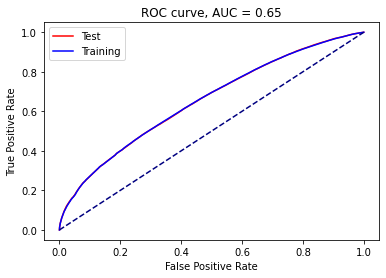

In [25]:
y_testprobability = gcv_rf.predict_proba(X_test)
y_trainprobability = gcv_rf.predict_proba(X_train)

def roc(y, prob):
    fpr, tpr, _ = roc_curve(y, prob, pos_label='Not Functional')
    return fpr, tpr
fpr_test, tpr_test = roc(y_test, y_testprobability[:,1])
fpr_train, tpr_train = roc(y_train, y_trainprobability[:,1])
auc = roc_auc_score(y_test, y_testprobability[:,1], multi_class = 'ovr')
plt.plot(fpr_test, tpr_test,'-r')
plt.plot(fpr_train, tpr_train,'-b')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve, AUC = %.2f'%auc)
plt.legend(['Test','Training'])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.show()

#### Observations.

    By using Random Forrest we got a macro avg of 58% for precision and 60% recall.
    When it comes damage, Not Functional has high precision with 80% and recall of 61%.
    For Damage resulting in functional, it has a precision of 37% and recall of 60%.
    The ROC Curve has an AUC of 0.65, same as the Logistic Regression and not much difference from Gradient Boosting.

### Conclusion

##### Report of Gradient Boosting

                precision    recall  f1-score   support

    Functional       0.34      0.66      0.45     80600
Not Functional       0.79      0.51      0.62    207162

      accuracy                           0.55    287762
     macro avg       0.57      0.58      0.53    287762
  weighted avg       0.67      0.55      0.57    287762



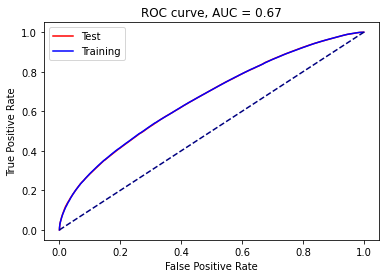

In [29]:
gb_model = Pipeline([('processing_pipeline', processing_pipeline),('model', GradientBoostingClassifier(n_estimators=300))])
gb_model.fit(X_train,y_train)
gb_predict = gb_model.predict(X_test)
print(classification_report(y_test, decision_predict))
##### ROC Curve Gradient Boosting#####
y_testprobability = gb_model.predict_proba(X_test)
y_trainprobability = gb_model.predict_proba(X_train)

def roc(y, prob):
    fpr, tpr, _ = roc_curve(y, prob, pos_label='Not Functional')
    return fpr, tpr
fpr_test, tpr_test = roc(y_test, y_testprobability[:,1])
fpr_train, tpr_train = roc(y_train, y_trainprobability[:,1])
auc = roc_auc_score(y_test, y_testprobability[:,1], multi_class = 'ovr')
plt.plot(fpr_test, tpr_test,'-r')
plt.plot(fpr_train, tpr_train,'-b')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve, AUC = %.2f'%auc)
plt.legend(['Test','Training'])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.show()

##### Report of Logistic Regression

                precision    recall  f1-score   support

    Functional       0.37      0.60      0.46     80600
Not Functional       0.79      0.60      0.69    207162

      accuracy                           0.60    287762
     macro avg       0.58      0.60      0.57    287762
  weighted avg       0.67      0.60      0.62    287762



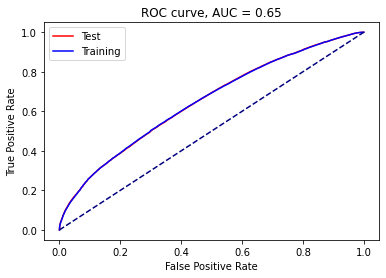

In [31]:
logistic_model = Pipeline([('processing_pipeline', processing_pipeline),('model', LogisticRegression(C=500, class_weight='balanced', solver='liblinear'))])
logistic_model.fit(X_train,y_train)
logistic_predict = logistic_model.predict(X_test)
print(classification_report(y_test, logistic_predict))

##### ROC Curve Logistic Regression#####
y_testprobability = logistic_model.predict_proba(X_test)
y_trainprobability = logistic_model.predict_proba(X_train)

def roc(y, prob):
    fpr, tpr, _ = roc_curve(y, prob, pos_label='Not Functional')
    return fpr, tpr
fpr_test, tpr_test = roc(y_test, y_testprobability[:,1])
fpr_train, tpr_train = roc(y_train, y_trainprobability[:,1])
auc = roc_auc_score(y_test, y_testprobability[:,1], multi_class = 'ovr')
plt.plot(fpr_test, tpr_test,'-r')
plt.plot(fpr_train, tpr_train,'-b')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve, AUC = %.2f'%auc)
plt.legend(['Test','Training'])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.show()

    From above other than Decision Tree, Random Forrest, Gradient Boosting  and Logistic Regression have shown better precision and recall values.
    The ROC curve was better for Gradient Boosting with 0.67 AUC and Random Forrest and Logistic Regression at 0.65 AUC.
    Random Forest has taken more time compared to Logistic Regression and Gradient Boosting.
    Logistic Regression and Gradient Boosting Models are preferred over Random Forrest and Decision Tree.

##### Improvements or Advancements to the Project.

    1. Collecting more Data will always be advantageous.
    2. We have used many hyper parameters for Random Forrest it has taken time but has given good results. Same can be done to rest of the models to acheive better validation scores, accuracy and recall values. More and different hyperparameters can be used to Tune the model
    3. We can combine these 3 to 4 weak models in creating a new models using Bagging or Boosting. This could result us in a better model with good ROC curve, Validation and Classification reports.